In [1]:
from cgeniepy.ecology import EcoModel
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

model = EcoModel("../model/muffin.u067bc.PO4.32P32Z32M16F.EXP3/", gemflag=['biogem', 'ecogem'])

## counting from 0
phyto_index = np.arange(0,32)
zoo_index = np.arange(32,64)
mixo_index = np.arange(64,96)
foram_index = np.arange(96,112)

In [2]:
temp = model.get_ts('ocn_temp')[['time (yr)', '_surT (ice-free) (C)']]
po4 = model.get_ts('ocn_PO4')[['time (yr)', 'surface (ice-free) PO4 (mol kg-1)']]
light = model.get_ts('misc_insol')[['time (yr)','mean insolation (W m-2)']]
mld = model.get_var('phys_MLD').mean(dim=['lat','lon'])
diversity = np.array([107, 107, 107,  32,  30,  30,  30,  30,  30,  30,  30,  30,  30,
        30,  30,  30])

## combine diversity with time
diversity = pd.DataFrame({'time':mld.data.time, 'diversity':diversity})

npp = model.get_var('eco2D_Uptake_Fluxes_C') * model.grid_volume().isel(zt=0) * 12.01 * 1e-18 * 365
int_npp = npp.sum(dim=['lat','lon']).data

poc_export =  model.get_ts('fexport_POC')[['time (yr)', 'global POC flux (mol yr-1)']]
poc_export['global POC flux (Pg yr-1)'] = poc_export['global POC flux (mol yr-1)'] * 12.01 * 1e-15

d13C = model.get_ts('ocn_DIC_13C')[['time (yr)', 'surface (ice-free) DIC_13C (o/oo)', 'benthic [> 2000 m] DIC_13C (o/oo)']]
d13C['delta_d13C'] = d13C['surface (ice-free) DIC_13C (o/oo)'] - d13C['benthic [> 2000 m] DIC_13C (o/oo)']

grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'


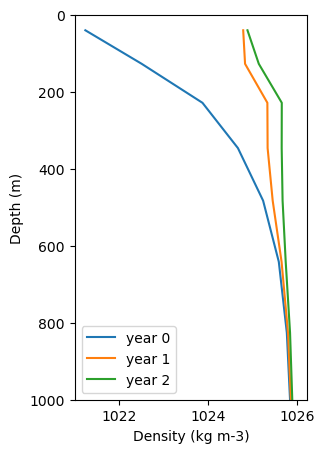

In [5]:
density = model.get_var('misc_rho')
fig, ax= plt.subplots(1,1, figsize=(3,5))
yr0 = density.mean(dim=['lat','lon'])[2]
yr1 = density.mean(dim=['lat','lon'])[3]
yr2 = density.mean(dim=['lat','lon'])[4]

ax.plot(yr0,yr0.zt,  label='year 0')
ax.plot(yr1, yr1.zt, label='year 1')
ax.plot(yr2, yr2.zt, label='year 2')

ax.set_ylim([0, 1000])
ax.set_xlabel('Density (kg m-3)')
ax.set_ylabel('Depth (m)')
ax.legend()
ax.invert_yaxis()
fig.savefig("../output/density_structure.png", dpi=300, bbox_inches='tight')

In [6]:
## plot total biomass evolution
sur_vol = model.grid_volume().isel(time=0, zt=0) #m3
scale_factor = sur_vol * 12E-3 *1E-15 #mmolC/m3*m3 = mmolC => Pg C
mixo_biomass = model.get_pft(list(mixo_index+1)) * scale_factor
phyto_biomass = model.get_pft(list(phyto_index+1)) * scale_factor
zoo_biomass = model.get_pft(list(zoo_index+1)) * scale_factor
foram_biomass = model.get_pft(list(foram_index+1)) * scale_factor

mixo_biomass = mixo_biomass.sum(dim=['variable', 'lat','lon']).data
phyto_biomass = phyto_biomass.sum(dim=['variable', 'lat','lon']).data
zoo_biomass = zoo_biomass.sum(dim=['variable', 'lat','lon']).data
foram_biomass = foram_biomass.sum(dim=['variable', 'lat','lon']).data

total_biomass = mixo_biomass + phyto_biomass + zoo_biomass + foram_biomass

# total_pfts = np.zeros(len(time_steps))

# for i in range(len(time_steps)):
#     for j in range(1, len(carbon_thresholds)):
#         pft_ij = model.get_pft(j).isel(time=i)
#         threshold = carbon_thresholds[j]
#         ## filter out the species with biomass less than threshold    
#         pft_ij_presence = xr.where(pft_ij > threshold, 1, 0.0)
#         if pft_ij_presence.sum() > 0:
#             total_pfts[i] += 1
            
# ## make total_pfts a xarray
# total_pfts = xr.DataArray(total_pfts, coords=[time_steps], dims=['time'])
# total_pfts = GriddedData(total_pfts, attrs={'long_name': 'Total PFTs',  'units': 'count'})

grid area returned in the unit of 'm2'
grid volume calculated in the unit of 'm3'


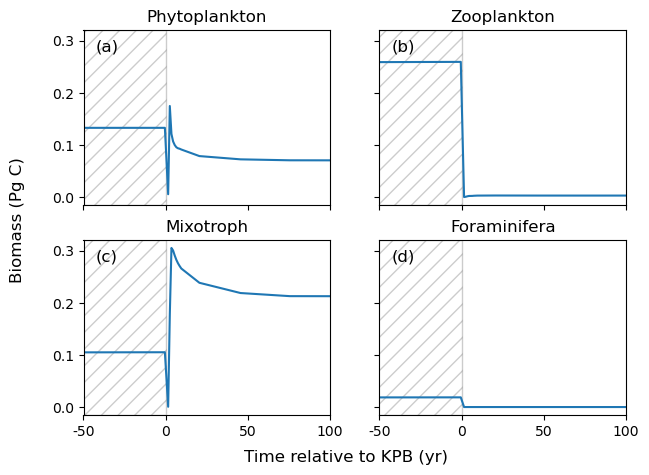

In [7]:
# plotting the biomass for each group

fig, axs = plt.subplots(2, 2, figsize=(7,5), sharex=True, sharey=True)

axs[0,0].plot(phyto_biomass.time, phyto_biomass, label='phytoplankton')
axs[0,1].plot(zoo_biomass.time, zoo_biomass, label='zooplankton')
axs[1,0].plot(mixo_biomass.time, mixo_biomass, label='mixotrophs')
axs[1,1].plot(foram_biomass.time, foram_biomass, label='foraminifera')
import string
for ax in axs.flat:
    # add letter labels
    letter = string.ascii_lowercase[axs.flatten().tolist().index(ax)]
    ax.text(0.05, 0.95, f"({letter})", transform=ax.transAxes, va='top', fontsize=12)
    ax.axvspan(0, 100, facecolor='none', edgecolor='black', hatch='//', alpha=0.2) 
    ax.set_xticks(np.arange(0,201,50))
    ax.set_xticklabels(np.arange(-100,101,50))
    ax.set_xlim(50,200)

fig.supxlabel('Time relative to KPB (yr)')
fig.supylabel('Biomass (Pg C)')

axs[0,0].set_title('Phytoplankton')
axs[0,1].set_title('Zooplankton')
axs[1,0].set_title('Mixotroph')
axs[1,1].set_title('Foraminifera')

fig.savefig("../output/biomass_evolution.png", dpi=300, bbox_inches='tight')

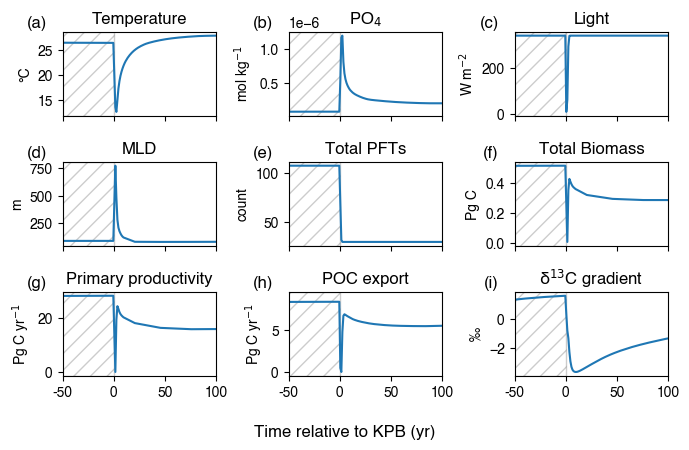

In [8]:
fig ,axs = plt.subplots(3,3, tight_layout=True, figsize=(7,4.5), sharex=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

axs[0,0].plot(temp['time (yr)'], temp['_surT (ice-free) (C)'])
axs[0,0].set_title('Temperature')
axs[0,0].set_ylabel('°C')

axs[0,1].plot(po4['time (yr)'], po4['surface (ice-free) PO4 (mol kg-1)'])
axs[0,1].set_title(r'PO$_4$')
axs[0,1].set_ylabel(r'mol kg$^{-1}$')

axs[0,2].plot(light['time (yr)'], light['mean insolation (W m-2)'])
axs[0,2].set_title('Light')
axs[0,2].set_ylabel(r'W m$^{-2}$')

axs[1,0].plot(mld.data.time, mld.data.values)
axs[1,0].set_title('MLD')
axs[1,0].set_ylabel('m')

axs[1,1].plot(diversity['time'], diversity['diversity'])
axs[1,1].set_title('Total PFTs')
axs[1,1].set_ylabel('count')

axs[1,2].plot(total_biomass.time, total_biomass.values)
axs[1,2].set_title('Total Biomass')
axs[1,2].set_ylabel('Pg C')

axs[2,0].plot(int_npp.time, int_npp.values)
axs[2,0].set_title('Primary productivity')
axs[2,0].set_ylabel(r'Pg C yr$^{-1}$')

axs[2,1].plot(poc_export['time (yr)'], poc_export['global POC flux (Pg yr-1)'])
axs[2,1].set_title('POC export')
axs[2,1].set_ylabel(r'Pg C yr$^{-1}$')

axs[2,2].plot(d13C['time (yr)'], d13C['delta_d13C'])
axs[2,2].set_title(r'δ$^{13}$C gradient')
axs[2,2].set_ylabel('‰')

import string
## change time ticks, 0,200 to -100,100
for ax in axs.flatten():
    ax.set_xticks(np.arange(0,201,50))
    ax.set_xticklabels(np.arange(-100,101,50))
    ax.set_xlim(50,200)
    ## label the subplot by letters
    letter = string.ascii_lowercase[axs.flatten().tolist().index(ax)]
    ax.text(-0.1, 1.2, f"({letter})", transform=ax.transAxes, fontsize=12, va='top', ha='right')        
    ax.axvspan(0, 100, facecolor='none', edgecolor='black', hatch='//', alpha=0.2) 
    

fig.supxlabel('Time relative to KPB (yr)')
fig.savefig('../output/fig1.png', dpi=300, bbox_inches='tight')

In [9]:
# d13c=model.get_ts('ocn_DIC_13C')
# d13c['delta_13C_DIC']= d13c['surface (ice-free) DIC_13C (o/oo)'] - d13c['benthic [> 2000 m] DIC_13C (o/oo)']
#d13c['surface (ice-free) DIC_13C (o/oo)'].plot()
#d13c['benthic [> 2000 m] DIC_13C (o/oo)'].plot()
# d13c['delta_13C_DIC'].plot()